## TEAM E - ENERGY PRICES TWITTER ANALYSIS

# Sections

* [1. Setup](#1)
  * [1.1 Start Hadoop](#1.1)  
  * [1.2 Search for Spark Installation](#1.2)
  * [1.3 Create SparkSession](#1.3)
  * [1.4 Check Twitter Files](#1.4)
  * [1.5 Create the DataFrame](#1.5)
* [2. User Analysis](#2)
  * [2.1 Basic Analysis](#2.1)
  * [2.2 Users Insights](#2.2)
  * [2.3 Emoji Analysis](#2.3)
* [3. Graph Analysis](#3)
* [4. Sentiment Analysis](#4)
* [5. Machine Learning: Clustering](#5)
  * [5.1 Clustering](#5.1)
  * [5.2 Linear Regression](#5.2)
  * [5.3 Cluestering](#5.3)
* [6. JSON Export](#6)

<a id='1'></a>
## 1. Setup

Since we are going to process data stored from HDFS let's start the service

<a id='1.1'></a>
### 1.1 Start Hadoop

Start Hadoop

Open a terminal and execute
```sh
hadoop-start.sh
```

<a id='1.2'></a>
### 1.2 Search for Spark Installation 
This step is required just because we are working in the course environment.

In [1]:
# pip install graphframes
# pip install textblob
# pip install nltk
# pip install sklearn
# pip install folium

In [2]:
import findspark
findspark.init()

In [3]:
import matplotlib.pyplot as plt # for visualization
import seaborn as sns # for visualization
from pyspark.sql.functions import *
from datetime import datetime
import pytz
import pandas as pd
pd.set_option('display.max_columns', None)
import os
from pyspark.sql.session import SparkSession
import re
#from pyspark.sql import functions as F
from collections import Counter
from textblob import TextBlob
import matplotlib.pyplot as plt
from itertools import permutations
from graphframes import GraphFrame

In [5]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages "org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.3" --jars "/usr/share/java/mariadb-java-client.jar,/opt/hive3/lib/hive-hcatalog-core-3.1.2.jar" pyspark-shell'

In [6]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages "graphframes:graphframes:0.8.2-spark3.2-s_2.12" --jars /opt/hive3/lib/hive-hcatalog-core-3.1.2.jar pyspark-shell'

<a id='1.3'></a>
### 1.3 Create SparkSession

By setting this environment variable we can include extra libraries in our Spark cluster

The first thing always is to create the SparkSession

In [7]:
from pyspark.sql.session import SparkSession

spark = (SparkSession.builder
    .appName("Twitter Analytics - DataFrames")
    .config("spark.sql.warehouse.dir","hdfs://localhost:9000/warehouse")
#    .config("spark.sql.legacy.timeParserPolicy","LEGACY")
    .enableHiveSupport()
    .getOrCreate())

Ivy Default Cache set to: /home/osbdet/.ivy2/cache
The jars for the packages stored in: /home/osbdet/.ivy2/jars
:: loading settings :: url = jar:file:/opt/spark3/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-20ebde32-8ee9-4439-b517-d81a36b5a94d;1.0
	confs: [default]
	found graphframes#graphframes;0.8.2-spark3.2-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 165ms :: artifacts dl 3ms
	:: modules in use:
	graphframes#graphframes;0.8.2-spark3.2-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	------------------------------------------------------------

<a id='1.4'></a>
### 1.4. Check Twitter Files

Reference: Lab 5.2 - NiFi Lab Twitter.pdf'**.

Check you have the data ready in HDFS (change the URL to fit where your files are stored)

http://localhost:50070/explorer.html#/ 

weet Object Model: https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/tweet

<a id='1.5'></a>
### 1.5 Create the DataFrame

The first step after creating the SparkSession is to create one or more DataFrames<br/>
We'll do some metadata and data inspection as we've studied in class:

In [8]:
tweets = (spark.read
               .json("hdfs://localhost:9000///user/osbdet/datalake/raw/twitter/group_ingestion/energy_prices"))
tweets.printSchema()

root
 |-- contributors: string (nullable = true)
 |-- coordinates: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- display_text_range: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- description: string (nullable = true)
 |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (contain

In [9]:
tweets.first()

Row(contributors=None, coordinates=None, created_at='Mon Mar 21 19:27:12 +0000 2022', display_text_range=None, entities=Row(hashtags=[], media=None, symbols=[], urls=[], user_mentions=[]), extended_entities=None, extended_tweet=None, favorite_count=0, favorited=False, filter_level='low', geo=None, id=1505989421279154180, id_str='1505989421279154180', in_reply_to_screen_name=None, in_reply_to_status_id=None, in_reply_to_status_id_str=None, in_reply_to_user_id=None, in_reply_to_user_id_str=None, is_quote_status=True, lang='ht', place=None, possibly_sensitive=None, quote_count=0, quoted_status=Row(contributors=None, coordinates=None, created_at='Mon Mar 21 14:22:47 +0000 2022', display_text_range=[28, 70], entities=Row(hashtags=[], media=None, symbols=[], urls=[Row(display_url='walesonline.co.uk/news/uk-news/e…', expanded_url='https://www.walesonline.co.uk/news/uk-news/energy-bill-price-rise-cause-22971008', indices=[47, 70], url='https://t.co/efjplVgboz')], user_mentions=[Row(id=14569746

In [10]:
from pyspark.sql.functions import *

def elements_by_tweets(df, entity):
    return (tweets.where(size(f"entities.{entity}.text") > 1)
                 .select("id","text",col(f"entities.{entity}.text").alias("elements")))


<a id='2'></a>
## 2. User Analysis

<a id='2.1'></a>
### 2.1 Basic Analysis

**Total number of tweets**<br/>

In [11]:
all_tweets = tweets.count()
all_tweets

12096

**Total number of unique tweets**<br/>

In [12]:
unique_tweets = tweets.select('text').distinct().count()
unique_tweets

5440

**Number of retweets**<br/>

In [13]:
tweets_repeated = all_tweets - unique_tweets
tweets_repeated

6656

**Total number of distinct users**<br/>

In [14]:
total_users = tweets.select("user.id").distinct().count()
total_users

10209

**Total number of verified users**<br/>

In [15]:
verified_users = tweets.select('user.screen_name').where(tweets.user.verified == True).distinct().count()
verified_users

321

**Total number of unverified users**<br/>

In [16]:
unverified_users = total_users - verified_users
unverified_users

9888

In [17]:
import matplotlib.pyplot as plt

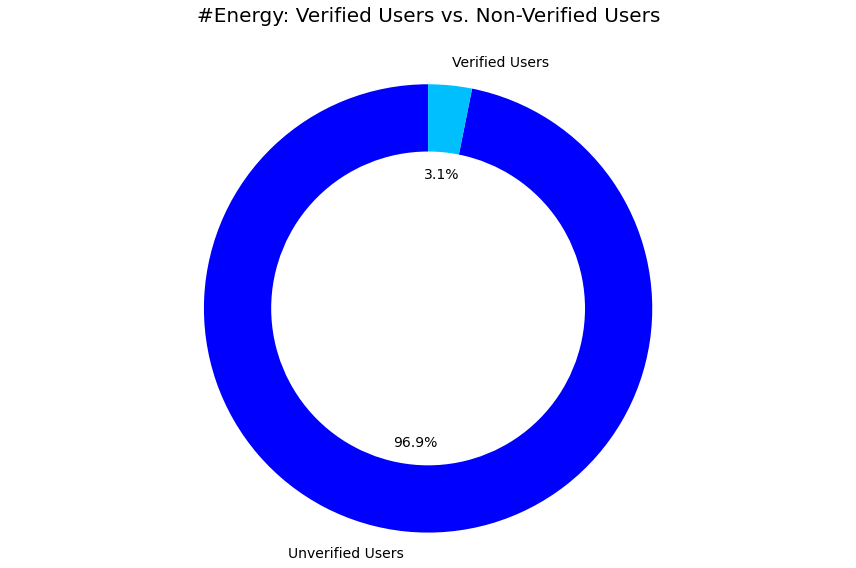

In [18]:
labels = ["Unverified Users"]+["Verified Users"]
colors = ['#0000FF','#00BFFF']
sizes = [unverified_users]+[verified_users]
explode = (0.5,0.5)


textprops = {"fontsize":14}
fig1, ax1 = plt.subplots(figsize=(12, 8))
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90, textprops=textprops)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.title("#Energy: Verified Users vs. Non-Verified Users", pad=40, size=20)
plt.yticks(rotation=45, size=18)
plt.tight_layout()
plt.show()

**Total number of users with geolocation enabled**<br/>

In [19]:
tweets.where("user.geo_enabled=true").select("user.id").distinct().count()

3353

**Total number of tweets per language**<br/>

In [20]:
from pyspark.sql.functions import *

df = (tweets
      .groupBy("lang")
      .agg(count("*").alias("total")))
      
df.toPandas()

,lang,total
0,en,11251
1,ro,2
2,sl,1
3,und,290
4,lv,1
5,pl,11
6,pt,14
7,tl,2
8,in,12
9,ko,3


**Top 10 users with more tweets posted**<br/>


In [21]:
df = (tweets
          .groupBy("user.screen_name")
          .agg(max("user.statuses_count").alias("tweets_posted"))
          .orderBy(desc("tweets_posted"))
          .limit(10))
df.toPandas()

,screen_name,tweets_posted
0,AmericanBanking,2893565
1,TraderMarcoCost,1723809
2,3_i_n,1717665
3,AndyVermaut,1621561
4,PhilDeCarolis,1601024
5,CFinancialNews,1433443
6,Moonbootica,1373466
7,llemj,1361783
8,7b73f39b85e1415,1333788
9,roblwilson,1312497


**Top 10 users with more followers**<br/>

In [22]:
df = (tweets
          .groupBy("user.screen_name")
          .agg(max("user.followers_count").alias("followers_count"))
          .orderBy(desc("followers_count"))
          .limit(10))
df.toPandas()

,screen_name,followers_count
0,SkyNews,7681965
1,FinancialTimes,7181087
2,MarketWatch,4228341
3,EconomicTimes,4161842
4,ajlnews,2768641
5,DXBMediaOffice,2285568
6,CyrilRamaphosa,2227100
7,livemint,2031787
8,WFP,1945116
9,thetimes,1693315


**Top 10 users with more mentions**<br/>

In [23]:
df = (tweets
          .select(explode("entities.user_mentions.screen_name").alias("user"))
          .groupBy(lower("user"))
          .agg(count("*").alias("mentions"))
          .orderBy(desc("mentions"))
          .limit(10))
df.toPandas()

,lower(user),mentions
0,vonderleyen,677
1,jogi83659514,374
2,lionelbarber,287
3,bbcr4today,287
4,bmay,283
5,misterminsoo,177
6,ukchange,166
7,davekeating,162
8,mrmarkethomas,144
9,paullewismoney,137


**Top 10 more popular hashtags**<br/>

In [24]:
df = (tweets
      .select(explode("entities.hashtags.text").alias("hashtag"))
      .groupBy("hashtag")
      .agg(count("*").alias("total"))
      .orderBy(desc("total"))
      .limit(10))
      
df.toPandas()

,hashtag,total
0,NazaninIsFree,284
1,EUCO,269
2,energy,65
3,Germany,48
4,Populism,47
5,RussianUkrainianWar,37
6,Energy,33
7,GMB,30
8,Russia,28
9,EU,23


**Average number of words per tweet**<br/>
``` sql
select avg(size(split(text, ' '))) as avg_words
from tweets
```

In [26]:
tweets.select(avg(size(split("text", " "))).alias("avg_words")).toPandas()

,avg_words
0,20.164104


**Max and average number of hashtags**<br/>

In [27]:
tweets.select(
            max(size("entities.hashtags")).alias("max"),
            avg(size("entities.hashtags")).alias("average")
).toPandas()

,max,average
0,11,0.180886


**Top locations tweeted**<br/>

In [28]:
tweets_location = (tweets.select("place.country_code",'place.country').filter(tweets['place.country_code'] != '').
                    groupby('country_code','country').
                    agg(count("*").alias("count")).orderBy(desc("count")).limit(10))

tweets_location_df = tweets_location.toPandas()
tweets_location_df

,country_code,country,count
0,GB,United Kingdom,23
1,US,United States,23
2,IN,India,4
3,BE,Belgium,4
4,CA,Canada,3
5,NG,Nigeria,3
6,MC,Monaco,2
7,ES,España,2
8,NZ,New Zealand,1
9,BW,Botswana,1


In [29]:
location_data = tweets.groupBy("user.location")\
    .agg(
        count("*").alias("total_count"))\
    .sort(col("total_count").desc())\
    .limit(50).toPandas().dropna()

location_data

,location,total_count
1,London,166
2,United States,119
3,UK,118
4,"London, England",111
5,United Kingdom,109
6,"England, United Kingdom",74
7,"Washington, DC",47
8,Scotland,46
9,"Brussels, Belgium",41
10,USA,41


In [30]:
location_data = tweets.groupBy("place.country")\
    .agg(
        count("*").alias("total_count"))\
    .sort(col("total_count").desc())\
    .limit(50).toPandas().dropna()

location_data

,country,total_count
1,United States,23
2,United Kingdom,23
3,Belgium,4
4,India,4
5,Canada,3
6,Nigeria,3
7,España,2
8,Monaco,2
9,Italia,1
10,Francia,1


<a id='2.2'></a>
### 2.2 User Insights

In [31]:
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from pyspark.sql.window import Window
from pyspark.sql.functions import col, row_number

In [32]:
tweets.select('user.screen_name','user.verified', 'user.favourites_count').limit(10).show()

+-------------+--------+----------------+
|  screen_name|verified|favourites_count|
+-------------+--------+----------------+
|IvabinSpended|   false|           24849|
|       JDogMT|   false|           18042|
|  Blueghost10|   false|            3082|
|shehzadyounis|   false|               0|
|   basilios17|   false|            3894|
|  kopitekev65|   false|            8672|
|  Blueghost10|   false|            3083|
|   biricikbal|   false|             565|
|       djconn|   false|           55045|
|   daveyrwill|   false|           39709|
+-------------+--------+----------------+



In [33]:
tweets.where('user.verified=true').select(
    'user.screen_name', 'user.verified', 'user.followers_count','user.friends_count').limit(10).show()

+-------------+--------+---------------+-------------+
|  screen_name|verified|followers_count|friends_count|
+-------------+--------+---------------+-------------+
|      TodayFM|    true|         296791|        17049|
|      eu_near|    true|         138219|         1304|
|     hblodget|    true|         147384|         1567|
|ING_Economics|    true|          80311|         2811|
|    Joe_Mayes|    true|          16305|         2153|
|rachelmorison|    true|           3721|          737|
|OctopusEnergy|    true|          35560|          637|
|  NeilGarratt|    true|           2526|         3484|
|  SMcPartland|    true|          16367|          227|
|      TodayFM|    true|         296791|        17049|
+-------------+--------+---------------+-------------+



In [34]:
top_followers_list = (tweets.select(
    'user.screen_name', 'user.followers_count','user.profile_image_url_https').orderBy(col('user.followers_count').desc()).limit(10).show())



+--------------+---------------+-----------------------+
|   screen_name|followers_count|profile_image_url_https|
+--------------+---------------+-----------------------+
|       SkyNews|        7681965|   https://pbs.twimg...|
|       SkyNews|        7677855|   https://pbs.twimg...|
|FinancialTimes|        7181087|   https://pbs.twimg...|
|   MarketWatch|        4228341|   https://pbs.twimg...|
| EconomicTimes|        4161842|   https://pbs.twimg...|
|       ajlnews|        2768641|   https://pbs.twimg...|
|DXBMediaOffice|        2285568|   https://pbs.twimg...|
|CyrilRamaphosa|        2227100|   https://pbs.twimg...|
|      livemint|        2031787|   https://pbs.twimg...|
|           WFP|        1945116|   https://pbs.twimg...|
+--------------+---------------+-----------------------+



In [35]:
users_df = (tweets
      .select('user.screen_name','user.verified','user.followers_count','user.friends_count',
              'user.favourites_count', 'entities', 'user.profile_image_url_https')
      .groupBy('screen_name','verified','followers_count','friends_count', 'profile_image_url_https')
      .agg({'favourites_count':'avg', 'entities':'count'}))

In [36]:
users_df.where('verified=true').orderBy('count(entities)').limit(5).show()

+---------------+--------+---------------+-------------+-----------------------+---------------+---------------------+
|    screen_name|verified|followers_count|friends_count|profile_image_url_https|count(entities)|avg(favourites_count)|
+---------------+--------+---------------+-------------+-----------------------+---------------+---------------------+
|         EEinEU|    true|          14476|         1441|   https://pbs.twimg...|              1|              11495.0|
|  Villaverde4NC|    true|           4272|         4185|   https://pbs.twimg...|              1|               1649.0|
|    SecGranholm|    true|         106119|          402|   https://pbs.twimg...|              1|                628.0|
|  Swissquote_ar|    true|          26770|            2|   https://pbs.twimg...|              1|                325.0|
|RepGarretGraves|    true|          16181|         1119|   https://pbs.twimg...|              1|                333.0|
+---------------+--------+---------------+------

In [37]:
users_df = users_df.withColumn('Reach_score', users_df.followers_count - users_df.friends_count)
users_df = users_df.withColumn('likes_per_follow', users_df['avg(favourites_count)'] / users_df.followers_count)
users_df.limit(5).toPandas()

,screen_name,verified,followers_count,friends_count,profile_image_url_https,count(entities),avg(favourites_count),Reach_score,likes_per_follow
0,TodayFM,True,296791,17049,https://pbs.twimg.com/profile_images/138561090...,2,27503.0,279742,0.092668
1,DrySeer,False,704,908,https://pbs.twimg.com/profile_images/744840121...,1,65509.0,-204,93.052557
2,Dr_BenWalsh,False,876,734,https://pbs.twimg.com/profile_images/136614263...,1,303.0,142,0.345890
3,EndrewPicache,False,653,16,https://pbs.twimg.com/profile_images/145806404...,1,4351.0,637,6.663093
4,BitcoinBling,False,88,449,https://pbs.twimg.com/profile_images/923334157...,1,4088.0,-361,46.454545


In [38]:
follower_users = users_df.orderBy(users_df.followers_count.desc())\
.select('screen_name','followers_count', 'profile_image_url_https')

w2 = Window.partitionBy("screen_name").orderBy(col("followers_count"))

follower_users = follower_users.withColumn("row",row_number().over(w2)) \
  .filter(col("row") == 1).drop("row").orderBy(follower_users.followers_count.desc()).limit(10).toPandas()

follower_users

,screen_name,followers_count,profile_image_url_https
0,SkyNews,7677855,https://pbs.twimg.com/profile_images/140033160...
1,FinancialTimes,7181087,https://pbs.twimg.com/profile_images/931161479...
2,MarketWatch,4228341,https://pbs.twimg.com/profile_images/705601245...
3,EconomicTimes,4161842,https://pbs.twimg.com/profile_images/128557120...
4,ajlnews,2768641,https://pbs.twimg.com/profile_images/140358880...
5,DXBMediaOffice,2285568,https://pbs.twimg.com/profile_images/144248190...
6,CyrilRamaphosa,2227100,https://pbs.twimg.com/profile_images/145541361...
7,livemint,2031787,https://pbs.twimg.com/profile_images/130322163...
8,WFP,1945116,https://pbs.twimg.com/profile_images/125837599...
9,thetimes,1693315,https://pbs.twimg.com/profile_images/127357299...


/tmp/ipykernel_51083/817784876.py:7: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``PIL.Image.open(urllib.request.urlopen(url))``.
  images.append(plt.imread(i, 'jpg'))


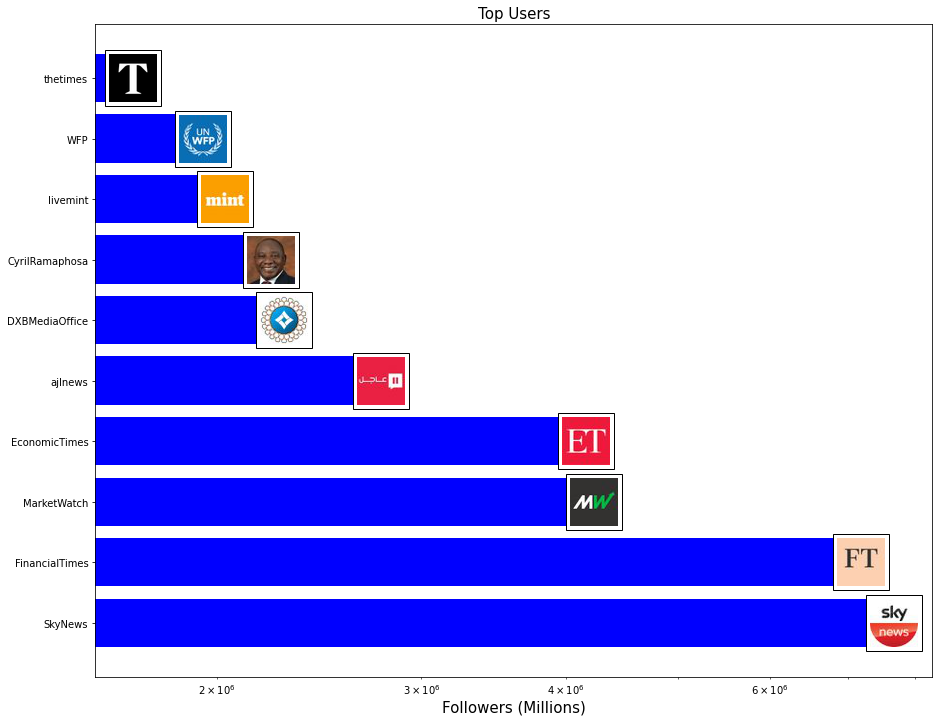

In [39]:
url = follower_users['profile_image_url_https'].tolist()

user_list = follower_users.screen_name.tolist()

images = []
for i in url:
    images.append(plt.imread(i, 'jpg'))
    
fig, ax = plt.subplots(figsize=(15, 12))

loc1 = 0

for image, score, j in zip(images, follower_users['followers_count'], range(len(follower_users))):
    imagebox = OffsetImage(image, zoom=1)
        
    ab= AnnotationBbox(imagebox, (score, loc1))
        
    loc1 += 1
    ax.add_artist(ab)

plt.draw()
plt.barh(follower_users['screen_name'], follower_users['followers_count'], color=["#0000FF"],)
ax.set_xscale('log')
plt.savefig('add_picture_matplotlib_figure.png', bbox_inches='tight')
plt.title('Top Users', size = 15)
plt.xlabel('Followers (Millions)', size = 15)
plt.show()

In [40]:
top_users = users_df.orderBy(users_df.Reach_score.desc())\
.select('screen_name','Reach_score', 'profile_image_url_https')

w2 = Window.partitionBy("screen_name").orderBy(col("Reach_score"))

top_users = top_users.withColumn("row",row_number().over(w2)) \
  .filter(col("row") == 1).drop("row").orderBy(top_users.Reach_score.desc()).limit(10).toPandas()

top_users

,screen_name,Reach_score,profile_image_url_https
0,SkyNews,7677832,https://pbs.twimg.com/profile_images/140033160...
1,FinancialTimes,7180187,https://pbs.twimg.com/profile_images/931161479...
2,MarketWatch,4228133,https://pbs.twimg.com/profile_images/705601245...
3,EconomicTimes,4161797,https://pbs.twimg.com/profile_images/128557120...
4,ajlnews,2768636,https://pbs.twimg.com/profile_images/140358880...
5,DXBMediaOffice,2285401,https://pbs.twimg.com/profile_images/144248190...
6,CyrilRamaphosa,2227092,https://pbs.twimg.com/profile_images/145541361...
7,livemint,2031717,https://pbs.twimg.com/profile_images/130322163...
8,WFP,1943534,https://pbs.twimg.com/profile_images/125837599...
9,thetimes,1692519,https://pbs.twimg.com/profile_images/127357299...


<a id='2.3'></a>
### 2.3. Emoji Analysis

In [41]:
#! pip3 install emojis

In [42]:
from pyspark.sql.functions import udf

import emojis

@udf("array<string>")
def get_emojis_udf(s):
    set = emojis.get(s)
    return [*set, ]

tweets.select(explode(get_emojis_udf("text")).alias("Emoji"))\
      .groupBy("emoji").agg(count("*").alias("total")).orderBy(desc("total")).limit(10)\
      .toPandas()

,emoji,total
0,🔴,110
1,🇪🇸,85
2,🔥,73
3,👇,41
4,🇪🇺,32
5,🎨,31
6,🎭,31
7,🐢,30
8,💨,30
9,🚨,26


<a id='3'></a>
## 3. Graph Analysis

In [43]:
hashtags_by_tweet = elements_by_tweets(tweets,'hashtags')
hashtags_by_tweet.limit(5).toPandas()   

,id,text,elements
0,1507331407089180673,RT @THemingford: Energy Price Increases: \n\nU...,"[SunakOut, JohnsonOut59, UselessGovtOut]"
1,1507331843229732880,RT @DaveKeating: The disagreement on energy pr...,"[EUCO, EUCO]"
2,1507332709890375684,RT @DaveKeating: The disagreement on energy pr...,"[EUCO, EUCO]"
3,1505126039827140612,And maybe the #KSA has realised that #China wi...,"[KSA, China, energy]"
4,1505613869598887937,RT @M_Mahmudul_Alam: Dynamics of technological...,"[innovation, energy]"


In [44]:
@udf("array<string>")
def upper_case(a):
    if not a:
        return a    
    return list(map(lambda x: x.upper(), a))

In [45]:
hashtags_by_tweets_fixed = hashtags_by_tweet.withColumn("hashtags",array_sort(array_distinct(upper_case("elements"))))
hashtags_by_tweets_fixed.limit(5).toPandas()

,id,text,elements,hashtags
0,1507331407089180673,RT @THemingford: Energy Price Increases: \n\nU...,"[SunakOut, JohnsonOut59, UselessGovtOut]","[JOHNSONOUT59, SUNAKOUT, USELESSGOVTOUT]"
1,1507331843229732880,RT @DaveKeating: The disagreement on energy pr...,"[EUCO, EUCO]",[EUCO]
2,1507332709890375684,RT @DaveKeating: The disagreement on energy pr...,"[EUCO, EUCO]",[EUCO]
3,1505126039827140612,And maybe the #KSA has realised that #China wi...,"[KSA, China, energy]","[CHINA, ENERGY, KSA]"
4,1505613869598887937,RT @M_Mahmudul_Alam: Dynamics of technological...,"[innovation, energy]","[ENERGY, INNOVATION]"


In [46]:
@udf("array<array<string>>")
def combine(a):
    return list(permutations(a, 2))

In [47]:
hashtag_pair_by_tweet = hashtags_by_tweets_fixed.select("id",combine("hashtags").alias("permutations"))
hashtag_pair_by_tweet.limit(5).toPandas()

,id,permutations
0,1507331407089180673,"[[JOHNSONOUT59, SUNAKOUT], [JOHNSONOUT59, USEL..."
1,1507331843229732880,[]
2,1507332709890375684,[]
3,1505126039827140612,"[[CHINA, ENERGY], [CHINA, KSA], [ENERGY, CHINA..."
4,1505613869598887937,"[[ENERGY, INNOVATION], [INNOVATION, ENERGY]]"


In [48]:
hashtags = (hashtag_pair_by_tweet
                     .select(explode("permutations").alias("pair"))
                     .select(col("pair")[0].alias("hashtag1"),
                             col("pair")[1].alias("hashtag2")))
                                                       
hashtags.limit(5).toPandas()

,hashtag1,hashtag2
0,JOHNSONOUT59,SUNAKOUT
1,JOHNSONOUT59,USELESSGOVTOUT
2,SUNAKOUT,JOHNSONOUT59
3,SUNAKOUT,USELESSGOVTOUT
4,USELESSGOVTOUT,JOHNSONOUT59


In [49]:
h_vertices = (hashtags.select("hashtag1").union(hashtags.select("hashtag2"))
           .distinct()           
           .withColumnRenamed("hashtag1","id"))
        
h_edges = (hashtags
            .withColumnRenamed("hashtag1","src")
            .withColumnRenamed("hashtag2","dst")
            .groupBy("src","dst")
            .agg(
                count("*").alias("occurrences")
            ))

In [50]:
h_vertices.count()

372

In [51]:
h_vertices.limit(5).toPandas()

,id
0,PROFITEERING
1,ENSV
2,PAYMENTS
3,GASPRICES
4,MNRG


In [52]:
h_edges.count()

1558

In [53]:
h_edges.orderBy(desc("occurrences")).limit(5).toPandas()

,src,dst,occurrences
0,GERMANY,POPULISM,47
1,POPULISM,GERMANY,47
2,ENERGY,GAS,17
3,GAS,ENERGY,17
4,ELECTRICITY,ENERGY,16


In [54]:
hashtag_graph = GraphFrame(h_vertices, h_edges)
hashtag_graph.cache()

GraphFrame(v:[id: string], e:[src: string, dst: string ... 1 more field])

In [55]:
#Which are the top 10 most common hashtag pairs?

hashtag_graph.edges.orderBy(desc("occurrences")).limit(10).toPandas()

,src,dst,occurrences
0,POPULISM,GERMANY,47
1,GERMANY,POPULISM,47
2,GAS,ENERGY,17
3,ENERGY,GAS,17
4,ELECTRICITY,ENERGY,16
5,ENERGY,ELECTRICITY,16
6,HEATING,EATING,13
7,EATING,HEATING,13
8,EU,RUSSIA,12
9,RUSSIA,EU,12


In [56]:
# How many communities/clusters are there?
pd.set_option('display.max_colwidth', 120)
(hashtag_graph.stronglyConnectedComponents(maxIter=10)
     .sort("component")
     .groupby("component")
     .agg(collect_list("id").alias("TwitterHashtags"))).toPandas()

,component,TwitterHashtags
0,8589934592,"[SEEDSALE, MASKS, BREXITLIES, ENSV, USO, FRANCE, OILPRICES, COSTOFLIVINGCRISIS, USA, ENERGY, COALIATION, SENATE, ENE..."
1,25769803776,"[GDP, FORECAST]"
2,25769803777,"[PENSIONER, POVERTY]"
3,25769803778,"[AIM, RNS, ANGS, PXEN]"
4,25769803781,"[SHIPPING, WHEAT, CORN, PANAMAX, AGRI, FREIGHT, MARKET, SUPRAMAX, FINANCING, SOYBEAN, CAPESIZE, CURVES, GLOBAL]"
5,34359738368,"[AMERICA, MAGA, TRUMP]"
6,51539607552,"[TRUCKERSFORFREEDOM, NOVACCINEMANDATES, NOVACCINEPASSPORTS, ONPOLI, BCPOLI, CDNPOLI, QCPOLI]"
7,60129542146,"[TEZOS, NFTART, CRYPTOART, NFT, NFTS]"
8,68719476737,"[NEXTPLAY, FOCUSBUDGET]"
9,68719476738,"[PMLNLONGMARCH, بنی_گالا_کے_چور]"


In [57]:
spark.sparkContext.setCheckpointDir('<pwd_output>/checkpoints')

(hashtag_graph.connectedComponents()
     .sort("component")
     .groupby("component")
     .agg(collect_list("id").alias("MMHashtags"))).toPandas()

,component,MMHashtags
0,8589934592,"[PROFITEERING, ENSV, PAYMENTS, GASPRICES, MNRG, RMW, SENATE, COUNCILTAX, BIDENPRICEHIKE, BANGLADESH, JAPAN, GOUGING,..."
1,25769803776,"[GDP, FORECAST]"
2,25769803777,"[PENSIONER, POVERTY]"
3,25769803778,"[PXEN, ANGS, RNS, AIM]"
4,25769803781,"[SUPRAMAX, FINANCING, GLOBAL, SHIPPING, PANAMAX, FREIGHT, CAPESIZE, MARKET, WHEAT, AGRI, CURVES, CORN, SOYBEAN]"
5,34359738368,"[MAGA, TRUMP, AMERICA]"
6,51539607552,"[CDNPOLI, BCPOLI, QCPOLI, TRUCKERSFORFREEDOM, NOVACCINEPASSPORTS, NOVACCINEMANDATES, ONPOLI]"
7,60129542146,"[CRYPTOART, NFTART, NFTS, NFT, TEZOS]"
8,68719476737,"[NEXTPLAY, FOCUSBUDGET]"
9,68719476738,"[PMLNLONGMARCH, بنی_گالا_کے_چور]"


In [58]:
#Which are the most relevant hashtags?
hashtag_rank = hashtag_graph.pageRank(resetProbability=0.15, maxIter=10)

In [59]:
hashtag_rank.vertices.orderBy(desc("pagerank")).limit(10).toPandas()

,id,pagerank
0,ENERGY,12.771050
1,OIL,4.936417
2,RUSSIA,3.684007
3,GAS,2.996479
4,OILPRICES,2.959851
5,COSTOFLIVINGCRISIS,2.931060
6,EU,2.835192
7,ENERGYPRICES,2.812497
8,ELECTRICITY,2.695288
9,BIDEN,2.606732


In [60]:
vertices_limit = hashtag_rank.vertices.orderBy(desc("pagerank")).limit(100)
vertices_list = vertices_limit.toPandas()['id'].tolist()

In [61]:
edges_limit = hashtag_rank.edges.where(
    (hashtag_rank.edges.src.isin(vertices_list)) &  (hashtag_rank.edges.dst.isin(vertices_list)))

In [62]:
max_value = hashtag_rank.vertices.agg({"pagerank": "max"}).collect()[0][0]
max_value

12.771049511251997

In [63]:
hashtag_rank.edges.orderBy(desc("weight")).limit(5).toPandas()

,src,dst,occurrences,weight
0,ENERGYMARKETS,NETZERO,1,1.0
1,INNOVATION,ENERGY,6,1.0
2,TRUDEAUDICTATORSHIPMUSTGO,TRUDEAUFORTREASON,1,1.0
3,بنی_گالا_کے_چور,PMLNLONGMARCH,1,1.0
4,ENERGYNEWSMONITOR,ENERGY,4,1.0


In [64]:
#!jupyter nbextension enable --py ipycytoscape
#!pip3 install ipycytoscape

In [65]:
#Updated
import random

hashtags_json = {}

vs = []
for v in vertices_limit.collect():
    data = {}
    data['id']=v.id
    data['label']=v.id
    data['pagerank']=v.pagerank
    data['color']="#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)])
    data['height'] = str(((v.pagerank/max_value)**0.5)*150)+'px'
    data['width'] = str(((v.pagerank/max_value)**0.5)*150)+'px'
    element = {}
    element['data']=data
    vs.append(element)
hashtags_json['nodes'] = vs

es = []
for e in edges_limit.collect():
    data = {}
    data['source']=e.src
    data['target']=e.dst
    data['occurrences']=e.occurrences
    data['weight']=e.weight   
    element = {}
    element['data']=data
    es.append(element)
hashtags_json['edges'] = es

In [125]:
import ipycytoscape

cytoscapeobj = ipycytoscape.CytoscapeWidget()
#adds the data
cytoscapeobj.graph.add_graph_from_json(hashtags_json)
#styles the nodes and egdes
cytoscapeobj.set_style([
            {
                'selector': 'node',
                'css': {'label': 'data(label)', 'background-color':'data(color)', 'width': 'data(width)', 'height': 'data(height)'}
            },                        
         
            {
                'selector': 'edge',
                'css': {"curve-style":"haystack","haystack-radius":0,"width":1.5,"opacity":'data(weight)*1.2',"line-color":"#a8eae5"}}            
])

cytoscapeobj

CytoscapeWidget(cytoscape_layout={'name': 'cola'}, cytoscape_style=[{'selector': 'node', 'css': {'label': 'dat…

<a id='4'></a>
## 4. Sentiment Analysis

Reference: https://www.analyticsvidhya.com/blog/2021/12/sentiment-analysis-on-tweets-with-lstm-for-beginners/

In [67]:
data = spark.read.options(header='false', inferschema='true').csv("noemoticon.csv")

In [68]:
data = data.withColumnRenamed("_c5", "text")
pd.set_option('display.max_colwidth', 120)

In [69]:
data.limit(10).toPandas()

,_c0,_c1,_c2,_c3,_c4,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,"@LOLTrish hey long time no see! Yes.. Rains a bit ,only a bit LOL , I'm fine thanks , how's you ?"
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [70]:
from pyspark.sql.functions import col

data.groupBy("_c0") \
    .count() \
    .orderBy(col("count").desc()) \
    .distinct() \
    .toPandas()
# _c0 represents the sentiment classification in the pre-labelled data
# 4 represent positive and 0 represent negative emotions

,_c0,count
0,4,800000
1,0,800000


In [71]:
data.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- _c1: long (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- text: string (nullable = true)



In [72]:
(trainingData, testData) = data.randomSplit([0.8, 0.2], seed = 30)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 1280282


Test Dataset Count: 319718


In [73]:
# Conducting some data cleaning on the tweets

from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer

from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [74]:
## regular expression tokenizer
# _c5 is the text of the Tweet
regexTokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\W")
#

In [75]:
## stop words
add_stopwords = ["http","https","amp","rt","t","c","the","@"]
stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(add_stopwords)
#

In [76]:
## bag of words count
countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=10000, minDF=5)
#

In [77]:
## convert string labels to indexes
label_stringIdx = StringIndexer(inputCol = "_c0", outputCol = "label")

In [78]:
### 4.3 Creating a classification model using random forest

rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100, seed=30)

In [79]:
# Build the pipeline

pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx, rf])

In [80]:
# Fit the model with the training data

pipelineFit = pipeline.fit(trainingData)

In [81]:
# Predict using the test set

predictions = pipelineFit.transform(testData)

In [82]:
# Prediction result on the annotated dataset. Note that prediction 0 is positive sentiment and prediction 1 is negative sentiment

predictions.select("text","_c0","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 30, truncate = 40)

predictions.groupBy('prediction').count().toPandas()

+----------------------------------------+---+----------------------------------------+-----+----------+
|                                    text|_c0|                             probability|label|prediction|
+----------------------------------------+---+----------------------------------------+-----+----------+
|Hello and welcome to my Newest of fri...|  4|  [0.572609352523585,0.4273906474764151]|  0.0|       0.0|
|@joeyTWOwheels you are so welcome ......|  4| [0.5701007120523165,0.4298992879476835]|  0.0|       0.0|
|Goodnight Twitterverse.   Thank you a...|  4| [0.5697162175655913,0.4302837824344086]|  0.0|       0.0|
|@sydneyeats hey hey...thanks for the ...|  4|[0.5690604569978438,0.43093954300215614]|  0.0|       0.0|
|You're welcome @cardboxdiva  Thank yo...|  4| [0.5681000216096372,0.4318999783903628]|  0.0|       0.0|
|@SuzeOrmanShow Thank you for your DM'...|  4|[0.5669263748325921,0.43307362516740794]|  0.0|       0.0|
|@shelleymulshine how cute this ist  l...|  4| [0.56675

,prediction,count
0,0.0,175969
1,1.0,143749


In [83]:
# Evaluate the model using Accuracy

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
print("Accuracy: %g" % (evaluator.evaluate(predictions)))

Accuracy: 0.714977


In [84]:
### 4.4 Apply the model to March Madness Tweets to get sentiment score classification

#Conducting a de-duplicate because there are many duplicated tweets in the dataset

unique_tweet = tweets.dropDuplicates(['text'])

mm_predictions = pipelineFit.transform(unique_tweet)
mm_predictions.limit(10).toPandas()

mm_predictions.select('id',"text", "probability","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 30, truncate = 40)

+-------------------+----------------------------------------+----------------------------------------+----------+
|                 id|                                    text|                             probability|prediction|
+-------------------+----------------------------------------+----------------------------------------+----------+
|1504438592231276544|@robcrilly @FT Zelenskyy: thank you f...|  [0.5391549755216539,0.460845024478346]|       0.0|
|1507390880805707779|@patrick_hally Hi Patrick! Thanks for...| [0.5363933935701041,0.4636066064298959]|       0.0|
|1504518314533560323|@citizensclimate Thank you @SenWhiteh...| [0.5347045911659946,0.4652954088340054]|       0.0|
|1507027769733136390|Thanks swamp rat Warner the only thin...| [0.5336173799404679,0.4663826200595322]|       0.0|
|1505865613243211779|@MrJustinLeigh @MrJustinLeigh 2/2  Yo...| [0.5303142949965267,0.4696857050034733]|       0.0|
|1507305238633619459|@PaulBilenkyj1 @BorisJohnson (2 of 2)...| [0.53031429499652

In [85]:
# Prediction zero is positive sentiment and prediction one is negative sentiment

mm_predictions.groupBy('prediction').count().toPandas()

,prediction,count
0,0.0,3998
1,1.0,1442


In [86]:
# Select all tweets with positive emotions
pd.set_option('display.max_colwidth', 120)
cols = ['id','text','probability','prediction']
neg_tweets = mm_predictions.filter(mm_predictions.prediction == 1).select(*cols)
neg_tweets

neg_tweets.select('id', 'text', 'prediction') \
    .orderBy('probability', ascending= False) \
    .limit(5).toPandas()

,id,text,prediction
0,1507411084525060096,"Not only is my daughter’s energy the best energy in my world, it is the most consistent. There is nothing like good…...",1.0
1,1505960628799750147,@sylvanguy We have been led to believe nuclear power is dangerous and only scarce oil and gas is what's best. So th…...,1.0
2,1504433467970539520,"@zarahsultana the UK govt don't control world gas &amp; oil prices, increased energy prices affect the production &a...",1.0
3,1507048997147623440,"RT @RenewablesGrid: In light of the #Ukraine 🇺🇦 war, the @IEA has released a 🔟Point Plan to Cut Oil Use ⬇️\n\n\n▶️Th...",1.0
4,1507363827024867329,@fortworthchris @trinmininggroup Bitcoin mining has a lot of similarities to real estate investing. Large upfront c…...,1.0


In [87]:
# Select all tweets with negative emotions
pd.set_option('display.max_colwidth', 120)
cols = ['id','text','probability','prediction']
pos_tweets = mm_predictions.filter(mm_predictions.prediction == 0).select(*cols)
pos_tweets

pos_tweets.select('id', 'text', 'prediction') \
    .orderBy('probability', ascending= True) \
    .limit(5).toPandas()

,id,text,prediction
0,1505989861785886721,RT @MrMarkEThomas: (2/13)\nWe cannot expect this government to solve the cost-of-living crisis.\n\n“Where other gove...,0.0
1,1505957030917464064,(2/13)\nWe cannot expect this government to solve the cost-of-living crisis.\n\n“Where other governments have suppor...,0.0
2,1507045719726825473,this will hike the price of bitcoin like never before; and may even give some legitimacy to the true value of its b…...,0.0
3,1504511096681603072,RT @sumant_sinha: Our economy has been facing the side-effects of crude oil price rise for a long time now. We can b...,0.0
4,1504422707693486080,Our economy has been facing the side-effects of crude oil price rise for a long time now. We can build a resilient… ...,0.0


In [88]:
pos_tweets.select('text') \
    .orderBy('probability', ascending= True) \
    .limit(100).toPandas()

,text
0,RT @MrMarkEThomas: (2/13)\nWe cannot expect this government to solve the cost-of-living crisis.\n\n“Where other gove...
1,(2/13)\nWe cannot expect this government to solve the cost-of-living crisis.\n\n“Where other governments have suppor...
2,this will hike the price of bitcoin like never before; and may even give some legitimacy to the true value of its b…...
3,RT @sumant_sinha: Our economy has been facing the side-effects of crude oil price rise for a long time now. We can b...
4,Our economy has been facing the side-effects of crude oil price rise for a long time now. We can build a resilient… ...
...,...
95,"RT @adilism1: Just being part of $kiba community is worth it, regardless of price action, which is astounding rn btw..."
96,"@mikeamyotte @Tory_Glory Our economy fell. Hardly call that a win.\n\nLeaving a free market, more difficulties with ..."
97,"RT @BCSC_Info: The B.C. Securities Commission analyzed 200,000 phone call records and over 100 bank and brokerage ac..."
98,"@Midge1415 @CateToward Me too. Energy, petrol and the high rise in the price of food must be very hard on those on… ..."


<a id='5'></a>
## 5. Machine Learning

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = (spark.read
               .csv("Clustering_Data.csv", header=True, inferSchema = True))
data.printSchema()

root
 |-- Entity: string (nullable = true)
 |-- Code: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Primary energy consumption (TWh): double (nullable = true)
 |-- Generation (Twh): double (nullable = true)
 |-- Population: integer (nullable = true)
 |-- Inflation: double (nullable = true)
 |-- GDP: integer (nullable = true)
 |-- PPP per capita (USD): integer (nullable = true)
 |-- Energy Imports %: double (nullable = true)
 |-- Temperature (Cº): double (nullable = true)
 |-- Unemployment (25+): double (nullable = true)
 |-- Energy Prices ($): double (nullable = true)
 |-- Energy Taxes (%): double (nullable = true)



In [90]:
data.toPandas()

,Entity,Code,Year,Primary energy consumption (TWh),Generation (Twh),Population,Inflation,GDP,PPP per capita (USD),Energy Imports %,Temperature (Cº),Unemployment (25+),Energy Prices ($),Energy Taxes (%)
0,Algeria,DZA,2019,705.040,74.348,43053054,-0.910,163812,10682.0,-177.12,23.22,11.40,0.03,NaN
1,Argentina,ARG,2019,961.881,132.683,44780675,50.600,455172,19687.0,13.03,14.55,7.95,0.05,7.6
2,Australia,AUS,2019,1780.442,253.679,25203200,3.400,1610556,48698.0,-190.02,21.94,4.00,0.17,2.3
3,Austria,AUT,2019,416.622,70.860,8955108,1.730,481209,51936.0,63.54,7.25,4.17,0.20,12.2
4,Bangladesh,BGD,2019,488.385,79.781,163046173,4.460,355689,4818.0,16.84,25.53,5.30,0.08,NaN
5,Belgium,BEL,2019,753.528,92.410,11694721,1.660,581848,48210.0,80.09,10.68,4.77,0.24,2.1
6,Brazil,BRA,2019,3445.401,615.353,211049519,4.280,1645837,14064.0,11.87,25.51,9.39,0.10,NaN
7,Bulgaria,BGR,2019,207.545,43.820,7000117,5.250,77907,22384.0,36.55,11.31,4.11,0.12,20.0
8,Canada,CAN,2019,3948.352,632.401,37411038,1.670,2015983,45857.0,-72.53,-6.36,4.71,0.12,1.5
9,Chile,CHL,2019,459.951,78.416,18952035,1.950,331250,23325.0,65.24,8.71,7.04,0.15,NaN


<a id='5.5'></a>
### 5.1 Pre Processing

In [91]:
from pyspark.sql.functions import col,isnan, when, count

data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]
   ).toPandas()

,Entity,Code,Year,Primary energy consumption (TWh),Generation (Twh),Population,Inflation,GDP,PPP per capita (USD),Energy Imports %,Temperature (Cº),Unemployment (25+),Energy Prices ($),Energy Taxes (%)
0,0,0,0,0,0,0,0,0,1,0,0,0,0,15


In [92]:
#Find null values on our dataset
data.filter(col("Energy Taxes (%)").isNull()).toPandas()

,Entity,Code,Year,Primary energy consumption (TWh),Generation (Twh),Population,Inflation,GDP,PPP per capita (USD),Energy Imports %,Temperature (Cº),Unemployment (25+),Energy Prices ($),Energy Taxes (%)
0,Algeria,DZA,2019,705.040,74.348,43053054,-0.910,163812,10682,-177.12,23.22,11.40,0.03,NaN
1,Bangladesh,BGD,2019,488.385,79.781,163046173,4.460,355689,4818,16.84,25.53,5.30,0.08,NaN
2,Brazil,BRA,2019,3445.401,615.353,211049519,4.280,1645837,14064,11.87,25.51,9.39,0.10,NaN
3,Chile,CHL,2019,459.951,78.416,18952035,1.950,331250,23325,65.24,8.71,7.04,0.15,NaN
4,Hong Kong,HKG,2019,344.813,34.687,7436157,2.050,369722,56154,98.68,22.60,2.49,0.17,NaN
5,Indonesia,IDN,2019,2475.353,281.135,270625567,1.600,1150245,11445,-103.09,26.14,2.11,0.10,NaN
6,Iran,IRN,2019,3428.863,306.298,82913893,36.900,1081383,12433,-33.40,17.68,9.81,0.04,NaN
7,Iraq,IRQ,2019,618.492,82.843,39309789,0.264,201472,9255,-229.39,22.58,13.74,0.04,NaN
8,Kazakhstan,KAZ,2019,861.057,101.552,18551428,7.630,194024,25337,-116.89,6.91,4.90,0.04,NaN
9,Mexico,MEX,2019,2144.652,313.654,127575529,3.970,1285518,17888,-4.67,21.31,3.01,0.05,NaN


In [93]:
# we assume that null values of the column Energy Taxes is due to the absence of taxes in these countries, thus we filled them with 0

In [94]:
#Check if the null values are corrected
data = data.na.fill(value=0, subset=["Energy Taxes (%)"])
data.toPandas()

,Entity,Code,Year,Primary energy consumption (TWh),Generation (Twh),Population,Inflation,GDP,PPP per capita (USD),Energy Imports %,Temperature (Cº),Unemployment (25+),Energy Prices ($),Energy Taxes (%)
0,Algeria,DZA,2019,705.040,74.348,43053054,-0.910,163812,10682.0,-177.12,23.22,11.40,0.03,0.0
1,Argentina,ARG,2019,961.881,132.683,44780675,50.600,455172,19687.0,13.03,14.55,7.95,0.05,7.6
2,Australia,AUS,2019,1780.442,253.679,25203200,3.400,1610556,48698.0,-190.02,21.94,4.00,0.17,2.3
3,Austria,AUT,2019,416.622,70.860,8955108,1.730,481209,51936.0,63.54,7.25,4.17,0.20,12.2
4,Bangladesh,BGD,2019,488.385,79.781,163046173,4.460,355689,4818.0,16.84,25.53,5.30,0.08,0.0
5,Belgium,BEL,2019,753.528,92.410,11694721,1.660,581848,48210.0,80.09,10.68,4.77,0.24,2.1
6,Brazil,BRA,2019,3445.401,615.353,211049519,4.280,1645837,14064.0,11.87,25.51,9.39,0.10,0.0
7,Bulgaria,BGR,2019,207.545,43.820,7000117,5.250,77907,22384.0,36.55,11.31,4.11,0.12,20.0
8,Canada,CAN,2019,3948.352,632.401,37411038,1.670,2015983,45857.0,-72.53,-6.36,4.71,0.12,1.5
9,Chile,CHL,2019,459.951,78.416,18952035,1.950,331250,23325.0,65.24,8.71,7.04,0.15,0.0


In [95]:
# For the column PPP per capita (USD), we decided to drop the row with a missing value as there was only one

In [96]:
data = data.na.drop(how='any')
data.toPandas()

,Entity,Code,Year,Primary energy consumption (TWh),Generation (Twh),Population,Inflation,GDP,PPP per capita (USD),Energy Imports %,Temperature (Cº),Unemployment (25+),Energy Prices ($),Energy Taxes (%)
0,Algeria,DZA,2019,705.040,74.348,43053054,-0.910,163812,10682,-177.12,23.22,11.40,0.03,0.0
1,Argentina,ARG,2019,961.881,132.683,44780675,50.600,455172,19687,13.03,14.55,7.95,0.05,7.6
2,Australia,AUS,2019,1780.442,253.679,25203200,3.400,1610556,48698,-190.02,21.94,4.00,0.17,2.3
3,Austria,AUT,2019,416.622,70.860,8955108,1.730,481209,51936,63.54,7.25,4.17,0.20,12.2
4,Bangladesh,BGD,2019,488.385,79.781,163046173,4.460,355689,4818,16.84,25.53,5.30,0.08,0.0
5,Belgium,BEL,2019,753.528,92.410,11694721,1.660,581848,48210,80.09,10.68,4.77,0.24,2.1
6,Brazil,BRA,2019,3445.401,615.353,211049519,4.280,1645837,14064,11.87,25.51,9.39,0.10,0.0
7,Bulgaria,BGR,2019,207.545,43.820,7000117,5.250,77907,22384,36.55,11.31,4.11,0.12,20.0
8,Canada,CAN,2019,3948.352,632.401,37411038,1.670,2015983,45857,-72.53,-6.36,4.71,0.12,1.5
9,Chile,CHL,2019,459.951,78.416,18952035,1.950,331250,23325,65.24,8.71,7.04,0.15,0.0


In [97]:
# Created a new feature "GDP per capita"

In [98]:
data = data.withColumn("GDP per capita", (data["GDP"]/data["Population"])*1000000)

In [99]:
#In order to select the best scaler for our fearures we need to check how our variables are distributed
data.summary().toPandas()

,summary,Entity,Code,Year,Primary energy consumption (TWh),Generation (Twh),Population,Inflation,GDP,PPP per capita (USD),Energy Imports %,Temperature (Cº),Unemployment (25+),Energy Prices ($),Energy Taxes (%),GDP per capita
0,count,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54
1,mean,None,None,2019.0,2736.815925925926,438.636,1.0840111675925925E8,4.180833333333333,1628405.0740740742,35214.055555555555,-20.50962962962962,14.769259259259261,5.335555555555555,0.1277777777777778,5.309259259259259,31718.995747967718
2,stddev,None,None,0.0,6367.107772650272,1128.5974739925052,2.6519911610661045E8,8.563927644927132,3815747.0298094717,23470.986944878707,130.3023581646029,8.60703723745797,4.264082403300664,0.07386031351104383,7.530397982880655,28659.837313401567
3,min,Algeria,ARE,2019,47.221,1.07,615730,-4.83,36039,4623,-581.35,-6.36,0.1,0.03,0.0,1208.531465821002
4,25%,None,None,2019,459.951,69.251,9684680,0.804,261726,13441,-33.4,8.76,2.9,0.08,0.0,7798.345183624891
5,50%,None,None,2019,961.881,132.683,37887771,2.06,455172,35638,24.12,11.66,4.07,0.11,3.1,21394.125576414346
6,75%,None,None,2019,2177.825,306.298,83429607,3.97,1439958,48698,60.65,22.6,6.14,0.17,6.7,51774.365458779335
7,max,United States,ZAF,2019,39360.93,7326.7,1433783692,50.6,22939580,110261,98.68,28.02,26.5,0.35,39.6,136051.5160865964


<a id='5.2'></a>
### 5.2 Linear Regression

In [100]:
# Supervised model
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
import pandas as pd
import matplotlib.pyplot as plt

In [101]:
import six
for i in data.columns:
    if not( isinstance(data.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to Energy Prices for ", i, data.stat.corr('Energy Prices ($)',i))

Correlation to Energy Prices for  Year nan
Correlation to Energy Prices for  Primary energy consumption (TWh) -0.11396447153764105
Correlation to Energy Prices for  Generation (Twh) -0.09597736764062864
Correlation to Energy Prices for  Population -0.16142669375956697
Correlation to Energy Prices for  Inflation -0.2915178999817168
Correlation to Energy Prices for  GDP 0.02968051696065817
Correlation to Energy Prices for  PPP per capita (USD) 0.44691798245183184
Correlation to Energy Prices for  Energy Imports % 0.3812756787613954
Correlation to Energy Prices for  Temperature (Cº) -0.23827412525861827
Correlation to Energy Prices for  Unemployment (25+) -0.20939367943254697
Correlation to Energy Prices for  Energy Prices ($) 1.0
Correlation to Energy Prices for  Energy Taxes (%) 0.544909924416101


Correlation to Energy Prices for  GDP per capita 0.5444054950967901


In [102]:
#The assembler creates a column with all the features as a vector
from pyspark.ml.feature import VectorAssembler
columns = [col for col in data.columns if col not in ['Year','Entity','Code','Energy Prices ($)']]

assembler = VectorAssembler()\
.setInputCols(columns)\
.setOutputCol("features_regression")

data_regression = assembler.transform(data)
data_regression = data_regression.select(['features_regression', 'Energy Prices ($)'])
data_regression.show(3)

+--------------------+-----------------+
| features_regression|Energy Prices ($)|
+--------------------+-----------------+
|[705.04,74.348,4....|             0.03|
|[961.881,132.683,...|             0.05|
|[1780.442,253.679...|             0.17|
+--------------------+-----------------+
only showing top 3 rows



In [103]:
# We scale the data using MinMax scaler
from pyspark.ml.feature import MinMaxScaler

scale=MinMaxScaler(inputCol='features_regression',outputCol='standardized_reg')
data_scale_reg=scale.fit(data_regression)
data_scale_output_reg=data_scale_reg.transform(data_regression)
data_scale_output_reg.toPandas()

,features_regression,Energy Prices ($),standardized_reg
0,"[705.04, 74.348, 43053054.0, -0.91, 163812.0, 10682.0, -177.12, 23.22, 11.4, 0.0, 3804.88687283369]",0.03,"[0.01673256013570228, 0.010002962202568244, 0.029610851711182756, 0.0707198268085874, 0.005578744352237935, 0.057356..."
1,"[961.881, 132.683, 44780675.0, 50.6, 455172.0, 19687.0, 13.03, 14.55, 7.95, 7.6, 10164.473849489763]",0.05,"[0.023265675594231008, 0.017966099843972464, 0.030816307767839987, 1.0, 0.01829992139643385, 0.14260020068535942, 0...."
2,"[1780.442, 253.679, 25203200.0, 3.4, 1610556.0, 48698.0, -190.02, 21.94, 4.0, 2.3, 63902.8377348908]",0.17,"[0.04408693669681484, 0.034482904541998434, 0.01715602821994984, 0.14847555475374347, 0.06874557082679922, 0.4172267..."
3,"[416.622, 70.86, 8955108.0, 1.73, 481209.0, 51936.0, 63.54, 7.25, 4.17, 12.2, 53735.70033996239]",0.20,"[0.009396238853983479, 0.009526825679156605, 0.005818842048605606, 0.11834746527151363, 0.01943673251223468, 0.44787..."
4,"[488.385, 79.781, 163046173.0, 4.46, 355689.0, 4818.0, 16.84, 25.53, 5.3, 0.0, 2181.5231443672096]",0.08,"[0.011221632637103763, 0.01074460490087542, 0.1133366411382283, 0.1675987732274941, 0.013956357228779602, 0.00184592..."
5,"[753.528, 92.41, 11694721.0, 1.66, 581848.0, 48210.0, 80.09, 10.68, 4.77, 2.1, 49753.046695171266]",0.24,"[0.017965921251541034, 0.01246855219278069, 0.007730420504613541, 0.11708461122136027, 0.02383076922472381, 0.412607..."
6,"[3445.401, 615.353, 211049519.0, 4.28, 1645837.0, 14064.0, 11.87, 25.51, 9.39, 0.0, 7798.345183624891]",0.10,"[0.08643753251569318, 0.0838539483976122, 0.1468312120976648, 0.1643514342413855, 0.07028598765579523, 0.08937124898..."
7,"[207.545, 43.82, 7000117.0, 5.25, 77907.0, 22384.0, 36.55, 11.31, 4.11, 20.0, 11129.38540884388]",0.12,"[0.004078068543469149, 0.005835675566470051, 0.004454737455259972, 0.1818509832220819, 0.0018280142795386966, 0.1681..."
8,"[3948.352, 632.401, 37411038.0, 1.67, 2015983.0, 45857.0, -72.53, -6.36, 4.71, 1.5, 53887.38478734538]",0.12,"[0.09923080521351978, 0.0861811202585989, 0.02567410727536205, 0.11726501894281074, 0.08644706947279462, 0.390333024..."
9,"[459.951, 78.416, 18952035.0, 1.95, 331250.0, 23325.0, 65.24, 8.71, 7.04, 0.0, 17478.334120847707]",0.15,"[0.010498373480863889, 0.010558272803840762, 0.012794247070951479, 0.12231643514342413, 0.01288931698377993, 0.17703..."


In [104]:
#Split the data into test and training
train, test = data_scale_output_reg.randomSplit([0.8,0.2], seed=4000)

In [105]:
# Train the model with the training set
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol = 'features_regression', labelCol='Energy Prices ($)', maxIter=10, regParam=0, elasticNetParam=1)
lr_model = lr.fit(train)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [-2.8848888140969574e-05,0.00011021709389994268,4.075637071833523e-11,-0.002405958738281516,1.235153109050018e-08,-4.6859307308181435e-07,0.0001766081483859484,-0.0006392151943888255,-0.0011860687733540802,0.004099068082250212,8.370143497213776e-07]
Intercept: 0.13256738439588503


In [106]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 0.044027
r2: 0.662737


In [107]:
train.describe().show()

+-------+-------------------+
|summary|  Energy Prices ($)|
+-------+-------------------+
|  count|                 42|
|   mean|0.12952380952380949|
| stddev|0.07673051928673241|
|    min|               0.04|
|    max|               0.35|
+-------+-------------------+



In [108]:
# Compare the predictions with the real values for the electricity price
lr_predictions = lr_model.transform(test)
lr_predictions.select("prediction","Energy Prices ($)","features_regression").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="Energy Prices ($)",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+-------------------+-----------------+--------------------+
|         prediction|Energy Prices ($)| features_regression|
+-------------------+-----------------+--------------------+
|0.15425060220803988|              0.1|[182.581,28.19,54...|
|0.19518453258598284|             0.12|[207.545,43.82,70...|
| 0.0649242601233666|             0.03|[705.04,74.348,4....|
|0.17296395829085032|              0.2|[986.019,51.164,5...|
|0.08702459209214967|             0.04|[1079.472,193.546...|
+-------------------+-----------------+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.469376


<a id='5.3'></a>
### 5.3 Clustering

In [109]:
#Unsupervised model
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator 
from pyspark.ml.feature import VectorAssembler 

columns = [col for col in data.columns if col not in ['Year','Entity','Code']]

assembler = VectorAssembler()\
.setInputCols(columns)\
.setOutputCol("features_clustering")

data_clustering = assembler.transform(data)
data_clustering.toPandas()

,Entity,Code,Year,Primary energy consumption (TWh),Generation (Twh),Population,Inflation,GDP,PPP per capita (USD),Energy Imports %,Temperature (Cº),Unemployment (25+),Energy Prices ($),Energy Taxes (%),GDP per capita,features_clustering
0,Algeria,DZA,2019,705.040,74.348,43053054,-0.910,163812,10682,-177.12,23.22,11.40,0.03,0.0,3804.886873,"[705.04, 74.348, 43053054.0, -0.91, 163812.0, 10682.0, -177.12, 23.22, 11.4, 0.03, 0.0, 3804.88687283369]"
1,Argentina,ARG,2019,961.881,132.683,44780675,50.600,455172,19687,13.03,14.55,7.95,0.05,7.6,10164.473849,"[961.881, 132.683, 44780675.0, 50.6, 455172.0, 19687.0, 13.03, 14.55, 7.95, 0.05, 7.6, 10164.473849489763]"
2,Australia,AUS,2019,1780.442,253.679,25203200,3.400,1610556,48698,-190.02,21.94,4.00,0.17,2.3,63902.837735,"[1780.442, 253.679, 25203200.0, 3.4, 1610556.0, 48698.0, -190.02, 21.94, 4.0, 0.17, 2.3, 63902.8377348908]"
3,Austria,AUT,2019,416.622,70.860,8955108,1.730,481209,51936,63.54,7.25,4.17,0.20,12.2,53735.700340,"[416.622, 70.86, 8955108.0, 1.73, 481209.0, 51936.0, 63.54, 7.25, 4.17, 0.2, 12.2, 53735.70033996239]"
4,Bangladesh,BGD,2019,488.385,79.781,163046173,4.460,355689,4818,16.84,25.53,5.30,0.08,0.0,2181.523144,"[488.385, 79.781, 163046173.0, 4.46, 355689.0, 4818.0, 16.84, 25.53, 5.3, 0.08, 0.0, 2181.5231443672096]"
5,Belgium,BEL,2019,753.528,92.410,11694721,1.660,581848,48210,80.09,10.68,4.77,0.24,2.1,49753.046695,"[753.528, 92.41, 11694721.0, 1.66, 581848.0, 48210.0, 80.09, 10.68, 4.77, 0.24, 2.1, 49753.046695171266]"
6,Brazil,BRA,2019,3445.401,615.353,211049519,4.280,1645837,14064,11.87,25.51,9.39,0.10,0.0,7798.345184,"[3445.401, 615.353, 211049519.0, 4.28, 1645837.0, 14064.0, 11.87, 25.51, 9.39, 0.1, 0.0, 7798.345183624891]"
7,Bulgaria,BGR,2019,207.545,43.820,7000117,5.250,77907,22384,36.55,11.31,4.11,0.12,20.0,11129.385409,"[207.545, 43.82, 7000117.0, 5.25, 77907.0, 22384.0, 36.55, 11.31, 4.11, 0.12, 20.0, 11129.38540884388]"
8,Canada,CAN,2019,3948.352,632.401,37411038,1.670,2015983,45857,-72.53,-6.36,4.71,0.12,1.5,53887.384787,"[3948.352, 632.401, 37411038.0, 1.67, 2015983.0, 45857.0, -72.53, -6.36, 4.71, 0.12, 1.5, 53887.38478734538]"
9,Chile,CHL,2019,459.951,78.416,18952035,1.950,331250,23325,65.24,8.71,7.04,0.15,0.0,17478.334121,"[459.951, 78.416, 18952035.0, 1.95, 331250.0, 23325.0, 65.24, 8.71, 7.04, 0.15, 0.0, 17478.334120847707]"


In [110]:
import numpy as np

In [111]:
#We also scale the data. We will have 2 new columns, one with the features that we are going to use in the model and another one with the same features but scaled
from pyspark.ml.feature import MinMaxScaler

scale=MinMaxScaler(inputCol='features_clustering',outputCol='standardized')
data_scale=scale.fit(data_clustering)
data_scale_output=data_scale.transform(data_clustering)
data_scale_output.toPandas()

,Entity,Code,Year,Primary energy consumption (TWh),Generation (Twh),Population,Inflation,GDP,PPP per capita (USD),Energy Imports %,Temperature (Cº),Unemployment (25+),Energy Prices ($),Energy Taxes (%),GDP per capita,features_clustering,standardized
0,Algeria,DZA,2019,705.040,74.348,43053054,-0.910,163812,10682,-177.12,23.22,11.40,0.03,0.0,3804.886873,"[705.04, 74.348, 43053054.0, -0.91, 163812.0, 10682.0, -177.12, 23.22, 11.4, 0.03, 0.0, 3804.88687283369]","[0.01673256013570228, 0.010002962202568244, 0.029610851711182756, 0.0707198268085874, 0.005578744352237935, 0.057356..."
1,Argentina,ARG,2019,961.881,132.683,44780675,50.600,455172,19687,13.03,14.55,7.95,0.05,7.6,10164.473849,"[961.881, 132.683, 44780675.0, 50.6, 455172.0, 19687.0, 13.03, 14.55, 7.95, 0.05, 7.6, 10164.473849489763]","[0.023265675594231008, 0.017966099843972464, 0.030816307767839987, 1.0, 0.01829992139643385, 0.14260020068535942, 0...."
2,Australia,AUS,2019,1780.442,253.679,25203200,3.400,1610556,48698,-190.02,21.94,4.00,0.17,2.3,63902.837735,"[1780.442, 253.679, 25203200.0, 3.4, 1610556.0, 48698.0, -190.02, 21.94, 4.0, 0.17, 2.3, 63902.8377348908]","[0.04408693669681484, 0.034482904541998434, 0.01715602821994984, 0.14847555475374347, 0.06874557082679922, 0.4172267..."
3,Austria,AUT,2019,416.622,70.860,8955108,1.730,481209,51936,63.54,7.25,4.17,0.20,12.2,53735.700340,"[416.622, 70.86, 8955108.0, 1.73, 481209.0, 51936.0, 63.54, 7.25, 4.17, 0.2, 12.2, 53735.70033996239]","[0.009396238853983479, 0.009526825679156605, 0.005818842048605606, 0.11834746527151363, 0.01943673251223468, 0.44787..."
4,Bangladesh,BGD,2019,488.385,79.781,163046173,4.460,355689,4818,16.84,25.53,5.30,0.08,0.0,2181.523144,"[488.385, 79.781, 163046173.0, 4.46, 355689.0, 4818.0, 16.84, 25.53, 5.3, 0.08, 0.0, 2181.5231443672096]","[0.011221632637103763, 0.01074460490087542, 0.1133366411382283, 0.1675987732274941, 0.013956357228779602, 0.00184592..."
5,Belgium,BEL,2019,753.528,92.410,11694721,1.660,581848,48210,80.09,10.68,4.77,0.24,2.1,49753.046695,"[753.528, 92.41, 11694721.0, 1.66, 581848.0, 48210.0, 80.09, 10.68, 4.77, 0.24, 2.1, 49753.046695171266]","[0.017965921251541034, 0.01246855219278069, 0.007730420504613541, 0.11708461122136027, 0.02383076922472381, 0.412607..."
6,Brazil,BRA,2019,3445.401,615.353,211049519,4.280,1645837,14064,11.87,25.51,9.39,0.10,0.0,7798.345184,"[3445.401, 615.353, 211049519.0, 4.28, 1645837.0, 14064.0, 11.87, 25.51, 9.39, 0.1, 0.0, 7798.345183624891]","[0.08643753251569318, 0.0838539483976122, 0.1468312120976648, 0.1643514342413855, 0.07028598765579523, 0.08937124898..."
7,Bulgaria,BGR,2019,207.545,43.820,7000117,5.250,77907,22384,36.55,11.31,4.11,0.12,20.0,11129.385409,"[207.545, 43.82, 7000117.0, 5.25, 77907.0, 22384.0, 36.55, 11.31, 4.11, 0.12, 20.0, 11129.38540884388]","[0.004078068543469149, 0.005835675566470051, 0.004454737455259972, 0.1818509832220819, 0.0018280142795386966, 0.1681..."
8,Canada,CAN,2019,3948.352,632.401,37411038,1.670,2015983,45857,-72.53,-6.36,4.71,0.12,1.5,53887.384787,"[3948.352, 632.401, 37411038.0, 1.67, 2015983.0, 45857.0, -72.53, -6.36, 4.71, 0.12, 1.5, 53887.38478734538]","[0.09923080521351978, 0.0861811202585989, 0.02567410727536205, 0.11726501894281074, 0.08644706947279462, 0.390333024..."
9,Chile,CHL,2019,459.951,78.416,18952035,1.950,331250,23325,65.24,8.71,7.04,0.15,0.0,17478.334121,"[459.951, 78.416, 18952035.0, 1.95, 331250.0, 23325.0, 65.24, 8.71, 7.04, 0.15, 0.0, 17478.334120847707]","[0.010498373480863889, 0.010558272803840762, 0.012794247070951479, 0.12231643514342413, 0.01288931698377993, 0.17703..."


In [112]:
# We choose the silhouette_score to decide the k (number of clusters). Values go between 2 and 20
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,20):   
    KMeans_algo=KMeans(featuresCol='standardized', k=i)   
    KMeans_fit=KMeans_algo.fit(data_scale_output)   
    output=KMeans_fit.transform(data_scale_output)
   
    
    score=evaluator.evaluate(output)   
    silhouette_score.append(score)   
    print("Silhouette Score:",score)

Silhouette Score: 0.3237269355196738
Silhouette Score: 0.3885376712528494
Silhouette Score: 0.3629898839622696
Silhouette Score: 0.3170413049163183
Silhouette Score: 0.2929020467608203


Silhouette Score: 0.3368526667014501


Silhouette Score: 0.247112520160373
Silhouette Score: 0.36337445681837566
Silhouette Score: 0.3203742024649322


Silhouette Score: 0.29239543783765193


Silhouette Score: 0.2866822187833514
Silhouette Score: 0.3549075154190876


Silhouette Score: 0.30695198067802765


Silhouette Score: 0.20158965483773444


Silhouette Score: 0.15514152244240692
Silhouette Score: 0.3243769098615585


Silhouette Score: 0.22844189730742798
Silhouette Score: 0.35923239337126345


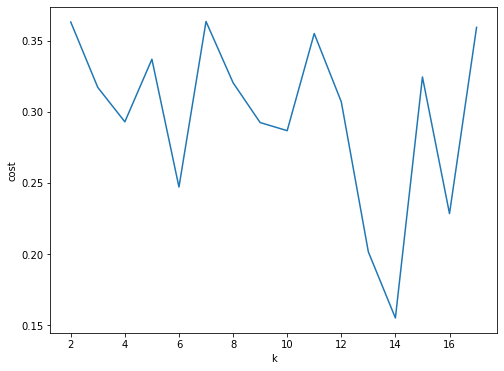

In [113]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sbs
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,18),silhouette_score[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [114]:
#We add the predicions (cluster number for each country) as a new column. We will use this informantion 
KMeans_algo=KMeans(featuresCol='features_clustering', k=5)
KMeans_fit=KMeans_algo.fit(data_scale_output)
    
output=KMeans_fit.transform(data_scale_output)

output.toPandas()

#kmeans = KMeans().setK(4).setSeed(1).setFeaturesCol("features_clustering")
#model = kmeans.fit(train_clustering)

,Entity,Code,Year,Primary energy consumption (TWh),Generation (Twh),Population,Inflation,GDP,PPP per capita (USD),Energy Imports %,Temperature (Cº),Unemployment (25+),Energy Prices ($),Energy Taxes (%),GDP per capita,features_clustering,standardized,prediction
0,Algeria,DZA,2019,705.040,74.348,43053054,-0.910,163812,10682,-177.12,23.22,11.40,0.03,0.0,3804.886873,"[705.04, 74.348, 43053054.0, -0.91, 163812.0, 10682.0, -177.12, 23.22, 11.4, 0.03, 0.0, 3804.88687283369]","[0.01673256013570228, 0.010002962202568244, 0.029610851711182756, 0.0707198268085874, 0.005578744352237935, 0.057356...",0
1,Argentina,ARG,2019,961.881,132.683,44780675,50.600,455172,19687,13.03,14.55,7.95,0.05,7.6,10164.473849,"[961.881, 132.683, 44780675.0, 50.6, 455172.0, 19687.0, 13.03, 14.55, 7.95, 0.05, 7.6, 10164.473849489763]","[0.023265675594231008, 0.017966099843972464, 0.030816307767839987, 1.0, 0.01829992139643385, 0.14260020068535942, 0....",0
2,Australia,AUS,2019,1780.442,253.679,25203200,3.400,1610556,48698,-190.02,21.94,4.00,0.17,2.3,63902.837735,"[1780.442, 253.679, 25203200.0, 3.4, 1610556.0, 48698.0, -190.02, 21.94, 4.0, 0.17, 2.3, 63902.8377348908]","[0.04408693669681484, 0.034482904541998434, 0.01715602821994984, 0.14847555475374347, 0.06874557082679922, 0.4172267...",0
3,Austria,AUT,2019,416.622,70.860,8955108,1.730,481209,51936,63.54,7.25,4.17,0.20,12.2,53735.700340,"[416.622, 70.86, 8955108.0, 1.73, 481209.0, 51936.0, 63.54, 7.25, 4.17, 0.2, 12.2, 53735.70033996239]","[0.009396238853983479, 0.009526825679156605, 0.005818842048605606, 0.11834746527151363, 0.01943673251223468, 0.44787...",0
4,Bangladesh,BGD,2019,488.385,79.781,163046173,4.460,355689,4818,16.84,25.53,5.30,0.08,0.0,2181.523144,"[488.385, 79.781, 163046173.0, 4.46, 355689.0, 4818.0, 16.84, 25.53, 5.3, 0.08, 0.0, 2181.5231443672096]","[0.011221632637103763, 0.01074460490087542, 0.1133366411382283, 0.1675987732274941, 0.013956357228779602, 0.00184592...",2
5,Belgium,BEL,2019,753.528,92.410,11694721,1.660,581848,48210,80.09,10.68,4.77,0.24,2.1,49753.046695,"[753.528, 92.41, 11694721.0, 1.66, 581848.0, 48210.0, 80.09, 10.68, 4.77, 0.24, 2.1, 49753.046695171266]","[0.017965921251541034, 0.01246855219278069, 0.007730420504613541, 0.11708461122136027, 0.02383076922472381, 0.412607...",0
6,Brazil,BRA,2019,3445.401,615.353,211049519,4.280,1645837,14064,11.87,25.51,9.39,0.10,0.0,7798.345184,"[3445.401, 615.353, 211049519.0, 4.28, 1645837.0, 14064.0, 11.87, 25.51, 9.39, 0.1, 0.0, 7798.345183624891]","[0.08643753251569318, 0.0838539483976122, 0.1468312120976648, 0.1643514342413855, 0.07028598765579523, 0.08937124898...",2
7,Bulgaria,BGR,2019,207.545,43.820,7000117,5.250,77907,22384,36.55,11.31,4.11,0.12,20.0,11129.385409,"[207.545, 43.82, 7000117.0, 5.25, 77907.0, 22384.0, 36.55, 11.31, 4.11, 0.12, 20.0, 11129.38540884388]","[0.004078068543469149, 0.005835675566470051, 0.004454737455259972, 0.1818509832220819, 0.0018280142795386966, 0.1681...",0
8,Canada,CAN,2019,3948.352,632.401,37411038,1.670,2015983,45857,-72.53,-6.36,4.71,0.12,1.5,53887.384787,"[3948.352, 632.401, 37411038.0, 1.67, 2015983.0, 45857.0, -72.53, -6.36, 4.71, 0.12, 1.5, 53887.38478734538]","[0.09923080521351978, 0.0861811202585989, 0.02567410727536205, 0.11726501894281074, 0.08644706947279462, 0.390333024...",0
9,Chile,CHL,2019,459.951,78.416,18952035,1.950,331250,23325,65.24,8.71,7.04,0.15,0.0,17478.334121,"[459.951, 78.416, 18952035.0, 1.95, 331250.0, 23325.0, 65.24, 8.71, 7.04, 0.15, 0.0, 17478.334120847707]","[0.010498373480863889, 0.010558272803840762, 0.012794247070951479, 0.12231643514342413, 0.01288931698377993, 0.17703...",0


In [115]:
output.filter(col("prediction")==0).toPandas()

,Entity,Code,Year,Primary energy consumption (TWh),Generation (Twh),Population,Inflation,GDP,PPP per capita (USD),Energy Imports %,Temperature (Cº),Unemployment (25+),Energy Prices ($),Energy Taxes (%),GDP per capita,features_clustering,standardized,prediction
0,Algeria,DZA,2019,705.040,74.348,43053054,-0.910,163812,10682,-177.12,23.22,11.40,0.03,0.0,3804.886873,"[705.04, 74.348, 43053054.0, -0.91, 163812.0, 10682.0, -177.12, 23.22, 11.4, 0.03, 0.0, 3804.88687283369]","[0.01673256013570228, 0.010002962202568244, 0.029610851711182756, 0.0707198268085874, 0.005578744352237935, 0.057356...",0
1,Argentina,ARG,2019,961.881,132.683,44780675,50.600,455172,19687,13.03,14.55,7.95,0.05,7.6,10164.473849,"[961.881, 132.683, 44780675.0, 50.6, 455172.0, 19687.0, 13.03, 14.55, 7.95, 0.05, 7.6, 10164.473849489763]","[0.023265675594231008, 0.017966099843972464, 0.030816307767839987, 1.0, 0.01829992139643385, 0.14260020068535942, 0....",0
2,Australia,AUS,2019,1780.442,253.679,25203200,3.400,1610556,48698,-190.02,21.94,4.00,0.17,2.3,63902.837735,"[1780.442, 253.679, 25203200.0, 3.4, 1610556.0, 48698.0, -190.02, 21.94, 4.0, 0.17, 2.3, 63902.8377348908]","[0.04408693669681484, 0.034482904541998434, 0.01715602821994984, 0.14847555475374347, 0.06874557082679922, 0.4172267...",0
3,Austria,AUT,2019,416.622,70.860,8955108,1.730,481209,51936,63.54,7.25,4.17,0.20,12.2,53735.700340,"[416.622, 70.86, 8955108.0, 1.73, 481209.0, 51936.0, 63.54, 7.25, 4.17, 0.2, 12.2, 53735.70033996239]","[0.009396238853983479, 0.009526825679156605, 0.005818842048605606, 0.11834746527151363, 0.01943673251223468, 0.44787...",0
4,Belgium,BEL,2019,753.528,92.410,11694721,1.660,581848,48210,80.09,10.68,4.77,0.24,2.1,49753.046695,"[753.528, 92.41, 11694721.0, 1.66, 581848.0, 48210.0, 80.09, 10.68, 4.77, 0.24, 2.1, 49753.046695171266]","[0.017965921251541034, 0.01246855219278069, 0.007730420504613541, 0.11708461122136027, 0.02383076922472381, 0.412607...",0
5,Bulgaria,BGR,2019,207.545,43.820,7000117,5.250,77907,22384,36.55,11.31,4.11,0.12,20.0,11129.385409,"[207.545, 43.82, 7000117.0, 5.25, 77907.0, 22384.0, 36.55, 11.31, 4.11, 0.12, 20.0, 11129.38540884388]","[0.004078068543469149, 0.005835675566470051, 0.004454737455259972, 0.1818509832220819, 0.0018280142795386966, 0.1681...",0
6,Canada,CAN,2019,3948.352,632.401,37411038,1.670,2015983,45857,-72.53,-6.36,4.71,0.12,1.5,53887.384787,"[3948.352, 632.401, 37411038.0, 1.67, 2015983.0, 45857.0, -72.53, -6.36, 4.71, 0.12, 1.5, 53887.38478734538]","[0.09923080521351978, 0.0861811202585989, 0.02567410727536205, 0.11726501894281074, 0.08644706947279462, 0.390333024...",0
7,Chile,CHL,2019,459.951,78.416,18952035,1.950,331250,23325,65.24,8.71,7.04,0.15,0.0,17478.334121,"[459.951, 78.416, 18952035.0, 1.95, 331250.0, 23325.0, 65.24, 8.71, 7.04, 0.15, 0.0, 17478.334120847707]","[0.010498373480863889, 0.010558272803840762, 0.012794247070951479, 0.12231643514342413, 0.01288931698377993, 0.17703...",0
8,Colombia,COL,2019,534.511,75.040,50339443,4.010,300791,13441,-274.13,24.79,8.54,0.14,3.2,5975.254831,"[534.511, 75.04, 50339443.0, 4.01, 300791.0, 13441.0, -274.13, 24.79, 8.54, 0.14, 3.2, 5975.254831484726]","[0.012394912929736544, 0.010097425067878122, 0.034694965501887214, 0.1594804257622226, 0.0115594352855744, 0.0834737...",0
9,Czechia,CZE,2019,473.666,85.740,10689213,3.890,276914,38319,31.62,8.73,1.83,0.13,2.0,25905.929651,"[473.666, 85.74, 10689213.0, 3.89, 276914.0, 38319.0, 31.62, 8.73, 1.83, 0.13, 2.0, 25905.929650761005]","[0.010847233976321083, 0.011558050297380567, 0.0070288223481791735, 0.15731553310481688, 0.010516932731056739, 0.318...",0


In [116]:
output.filter(col("prediction")==2).toPandas()

,Entity,Code,Year,Primary energy consumption (TWh),Generation (Twh),Population,Inflation,GDP,PPP per capita (USD),Energy Imports %,Temperature (Cº),Unemployment (25+),Energy Prices ($),Energy Taxes (%),GDP per capita,features_clustering,standardized,prediction
0,Bangladesh,BGD,2019,488.385,79.781,163046173,4.460,355689,4818,16.84,25.53,5.30,0.08,0.0,2181.523144,"[488.385, 79.781, 163046173.0, 4.46, 355689.0, 4818.0, 16.84, 25.53, 5.3, 0.08, 0.0, 2181.5231443672096]","[0.011221632637103763, 0.01074460490087542, 0.1133366411382283, 0.1675987732274941, 0.013956357228779602, 0.00184592...",2
1,Brazil,BRA,2019,3445.401,615.353,211049519,4.280,1645837,14064,11.87,25.51,9.39,0.10,0.0,7798.345184,"[3445.401, 615.353, 211049519.0, 4.28, 1645837.0, 14064.0, 11.87, 25.51, 9.39, 0.1, 0.0, 7798.345183624891]","[0.08643753251569318, 0.0838539483976122, 0.1468312120976648, 0.1643514342413855, 0.07028598765579523, 0.08937124898...",2
2,Egypt,EGY,2019,1079.472,193.546,100388076,13.600,396328,11951,-7.39,23.00,6.09,0.04,3.3,3947.958919,"[1079.472, 193.546, 100388076.0, 13.6, 396328.0, 11951.0, -7.39, 23.0, 6.09, 0.04, 3.3, 3947.9589189457124]","[0.0262567696169293, 0.026274327259225485, 0.06961664553313536, 0.33249143063323106, 0.015730711683403016, 0.0693689...",2
3,Japan,JPN,2019,5187.154,952.384,126860299,0.641,5103110,41380,93.02,11.13,2.39,0.21,5.1,40226.217660,"[5187.154, 952.384, 126860299.0, 0.641, 5103110.0, 41380.0, 93.02, 11.13, 2.39, 0.21, 5.1, 40226.217660104994]","[0.13074149274493538, 0.12986104949335414, 0.08808776943619677, 0.09870106440555655, 0.22123526663409818, 0.34795244...",2
4,Mexico,MEX,2019,2144.652,313.654,127575529,3.970,1285518,17888,-4.67,21.31,3.01,0.05,0.0,10076.524942,"[2144.652, 313.654, 127575529.0, 3.97, 1285518.0, 17888.0, -4.67, 21.31, 3.01, 0.05, 0.0, 10076.524942334356]","[0.053351135096411276, 0.042669913713905834, 0.08858682468928929, 0.15875879487642072, 0.05455396613126328, 0.125570...",2
5,Pakistan,PAK,2019,989.031,145.386,216565317,8.620,261726,4623,24.12,20.75,4.40,0.08,12.0,1208.531466,"[989.031, 145.386, 216565317.0, 8.62, 261726.0, 4623.0, 24.12, 20.75, 4.4, 0.08, 12.0, 1208.531465821002]","[0.023956274387644267, 0.019700148656156536, 0.15067988730269985, 0.242648385350893, 0.009853803828848998, 0.0, 0.89...",2
6,Philippines,PHL,2019,562.217,100.381,108116622,0.697,393737,7954,45.77,25.82,1.60,0.17,5.0,3641.780447,"[562.217, 100.381, 108116622.0, 0.697, 393737.0, 7954.0, 45.77, 25.82, 1.6, 0.17, 5.0, 3641.780447043564]","[0.013099654372473478, 0.013556649735244614, 0.07500927654702905, 0.09971134764567924, 0.015617585071234182, 0.03153...",2
7,Russia,RUS,2019,8279.179,1058.466,145872260,3.080,1647568,26456,-83.67,-5.16,3.97,0.05,1.3,11294.594325,"[8279.179, 1058.466, 145872260.0, 3.08, 1647568.0, 26456.0, -83.67, -5.16, 3.97, 0.05, 1.3, 11294.594325199321]","[0.20939153820363274, 0.14434198833410913, 0.10135345880694478, 0.14270250766732814, 0.07036156548893466, 0.20667752...",2


In [117]:
output.filter(col("prediction")==3).toPandas()

,Entity,Code,Year,Primary energy consumption (TWh),Generation (Twh),Population,Inflation,GDP,PPP per capita (USD),Energy Imports %,Temperature (Cº),Unemployment (25+),Energy Prices ($),Energy Taxes (%),GDP per capita,features_clustering,standardized,prediction
0,India,IND,2019,9460.984,1378.174,1366417756,3.57,2946061,6118,34.31,24.68,2.9,0.09,3.5,2156.047071,"[9460.984, 1378.174, 1366417756.0, 3.57, 2946061.0, 6118.0, 34.31, 24.68, 2.9, 0.09, 3.5, 2156.0470705710004]","[0.2394524261244341, 0.18798437813539587, 0.9529950865591567, 0.1515424860184016, 0.12705555005664845, 0.01415210435...",3


In [118]:
pandas4_df = output.filter(col("prediction")==4).toPandas()

In [119]:
pandas4_df

,Entity,Code,Year,Primary energy consumption (TWh),Generation (Twh),Population,Inflation,GDP,PPP per capita (USD),Energy Imports %,Temperature (Cº),Unemployment (25+),Energy Prices ($),Energy Taxes (%),GDP per capita,features_clustering,standardized,prediction
0,Indonesia,IDN,2019,2475.353,281.135,270625567,1.60,1150245,11445,-103.09,26.14,2.11,0.10,0.0,4250.319040,"[2475.353, 281.135, 270625567.0, 1.6, 1150245.0, 11445.0, -103.09, 26.14, 2.11, 0.1, 0.0, 4250.319039516321]","[0.061762984510059835, 0.03823084157949555, 0.18840069284216948, 0.1160021648926574, 0.04864776149679213, 0.06457903...",4
1,United States,USA,2019,26291.360,4161.834,329064917,1.79,22939580,60236,7.31,7.63,3.08,0.11,0.7,69711.411989,"[26291.36, 4161.834, 329064917.0, 1.79, 22939580.0, 60236.0, 7.31, 7.63, 3.08, 0.11, 0.7, 69711.41198865633]","[0.6675569328755014, 0.5679735394771508, 0.22917703696198033, 0.11942991160021649, 1.0, 0.5264488157670535, 0.865638...",4


In [120]:
KMeans_fit.summary.clusterSizes

[42, 1, 8, 1, 2]

In [121]:
KMeans_fit.summary.trainingCost

4.240598203351231e+16

<a id='6'></a>
### 6. Export JSON

In [123]:
output.coalesce(1).write.format('json').save('ML_GroupE_Json')